# 2021-08-27 Further `oBEo` tests

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/9efda813a50c25fe64a358d5d5233b1b603defac

(Rerunning the code below for other commits is not guaranteed to give the same results)


## Init

In [6]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


## Unit tests, reproducing earlier results

Just the base model, no interaction

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


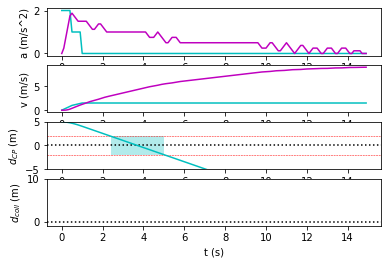

In [2]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True, surplus_action_vals = False)

Baseline kinematics, base model

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


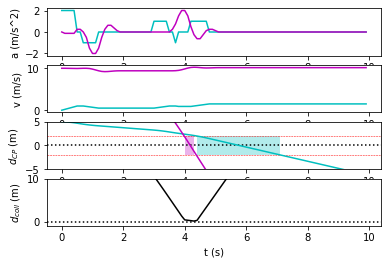

In [4]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), plot_beh_probs = False, 
                            plot_beh_activs = False, plot_beh_accs = False):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params)
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs)

run_baseline_kinematics(dist0s = (40,))

# Simplified case like in the Keio study

In [20]:
import math

def run_keio_scenario(time_step = 0.1, T_P = 0.5, sigma_O = 0.01, oBEo = False, ped_snapshot_times = None):
    INITIAL_POSITIONS = np.array([[0,-2.5], [13.9*2.29, 0]])
    GOALS = np.array([[0, 5], [-50, 0]])
    SPEEDS = np.array((0, 13.9))
    stop_dist = INITIAL_POSITIONS[1][0] - sc_scenario.SHARED_PARAMS.d_C
    CONST_ACCS = (None, -SPEEDS[1] ** 2 / (2 * stop_dist))

    # only a single move-forward action
    sc_scenario.DEFAULT_PARAMS.ctrl_deltas = np.array([0, 1.3])
    sc_scenario.i_NO_ACTION = np.argwhere(sc_scenario.DEFAULT_PARAMS.ctrl_deltas == 0)[0][0]
    sc_scenario.N_ACTIONS = len(sc_scenario.DEFAULT_PARAMS.ctrl_deltas)

    # set parameters and optional assumptions
    AFF_VAL_FCN = True
    (params, params_k) = get_default_params(oVA = AFF_VAL_FCN)
    params.T_P = T_P
    params.T_O = math.inf
    params.sigma_O = sigma_O
    optional_assumptions = get_assumptions_dict(default_value = False, oVA = AFF_VAL_FCN,
                                               oBEo = oBEo)  

    # run simulation
    SNAPSHOT_TIMES = (ped_snapshot_times, None)
    sc_simulation = SCSimulation(
            CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
            end_time = 8, optional_assumptions = optional_assumptions,
            const_accs = CONST_ACCS, agent_names = NAMES, 
            params = params, snapshot_times = SNAPSHOT_TIMES, time_step=time_step)
    sc_simulation.run()

    # plot and give some results feedback
    sc_simulation.do_plots(kinem_states=True, beh_probs=oBEo)
    for agent in sc_simulation.agents:
        ca_entered = np.nonzero(np.linalg.norm(agent.trajectory.pos, axis=0)
                                <= sc_scenario.SHARED_PARAMS.d_C)[0]
        if len(ca_entered) == 0:
            print('Agent %s did not enter the conflict area.' % agent.name)
        else:
            print('Agent %s entered conflict area at t = %.2f s' 
                  % (agent.name, sc_simulation.time_stamps[ca_entered[0]]))
          

As noted in the 2021-06-01 diary entry, with the default parameter settings I have been using before, `oBEo` has little or no effect on the tendency of the pedestrian to cross in front of a decelerating car, even if the pedestrian is very certain of the observation that the car is intending to pass in 2nd. And as already noted in the previous diary entry, the reason for this is that even with the deceleration, the predicted state of the car looks quite scary - i.e. requires a large acceleration to pass in front - see bottom right panel in the "snapshot" plot below from t = 4 s and note that the value for passing in front of the decelerating car, after having applied the 1.3 m/s speed increase, is V = -192.44.

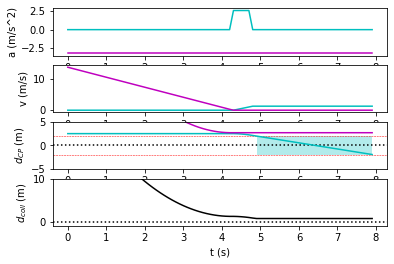

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


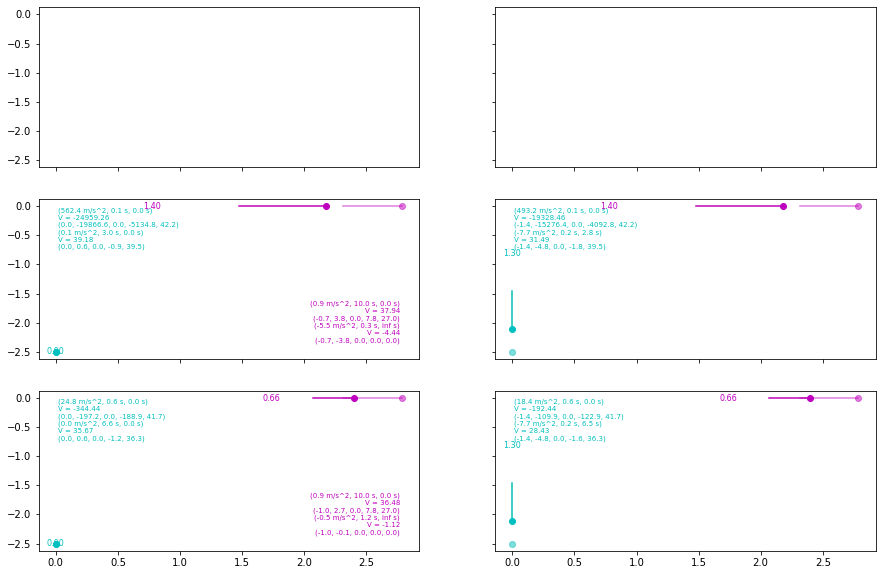

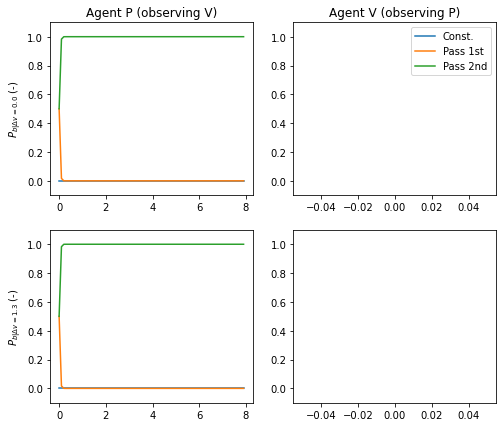

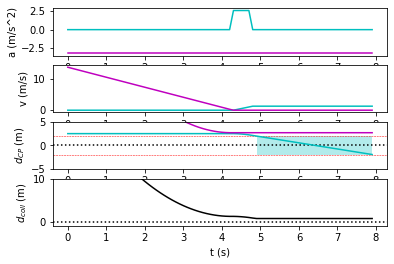

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.


In [23]:
run_keio_scenario(oBEo=False)
run_keio_scenario(oBEo=True, ped_snapshot_times=(4.0,))

---
One idea I had for how to fix this was to increase T_P from 0.5 s to a larger value, to see a larger predicted effect of the yielding deceleration, but that doesn't really help; see below for T_P = 1 s.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


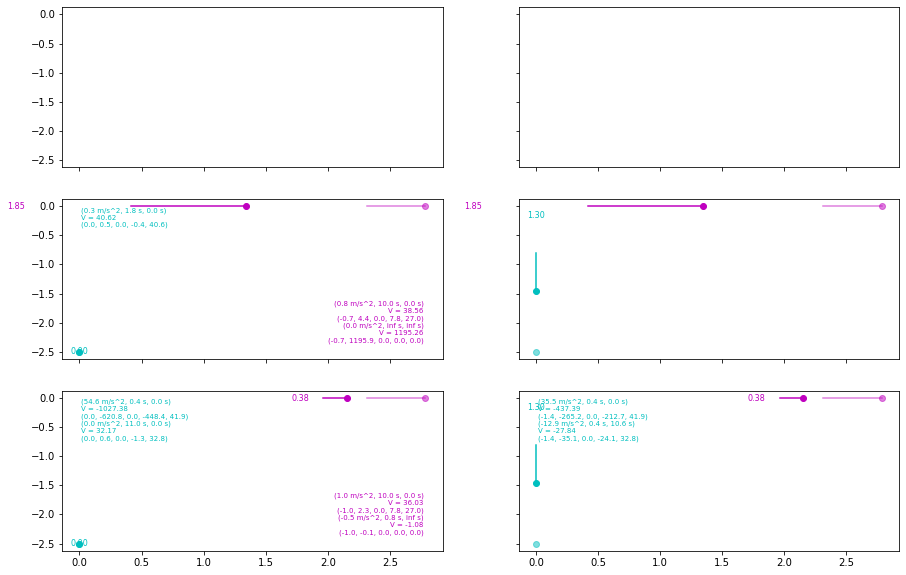

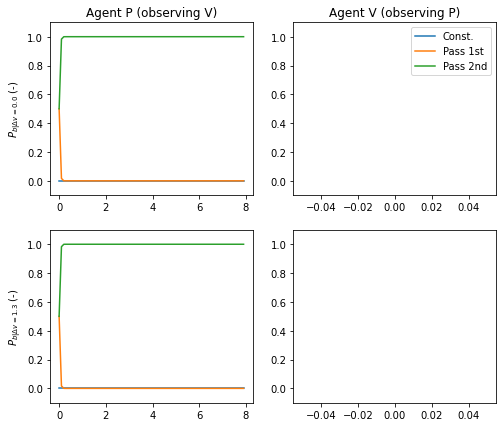

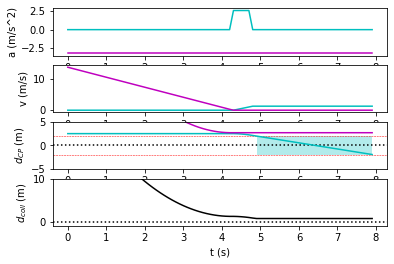

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.


In [24]:
run_keio_scenario(oBEo=True, ped_snapshot_times=(4.0,), T_P=1)

---
What I need to do instead to get the kind of behaviour I was hoping for is to reduce the simulation time step (and also decrease $\sigma_\mathrm{O}$ to get the behaviour probabilities to increase quickly enough with this smaller time step). As can be seen below, this has the model with yielding detection begin crossing 0.4 s than the model without yielding detection, similarly to the results in our VDDM paper (Pekkanen et al., 2021):

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


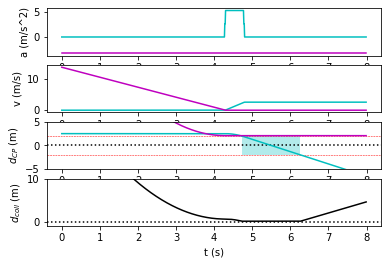

Agent P entered conflict area at t = 4.73 s
Agent V did not enter the conflict area.


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


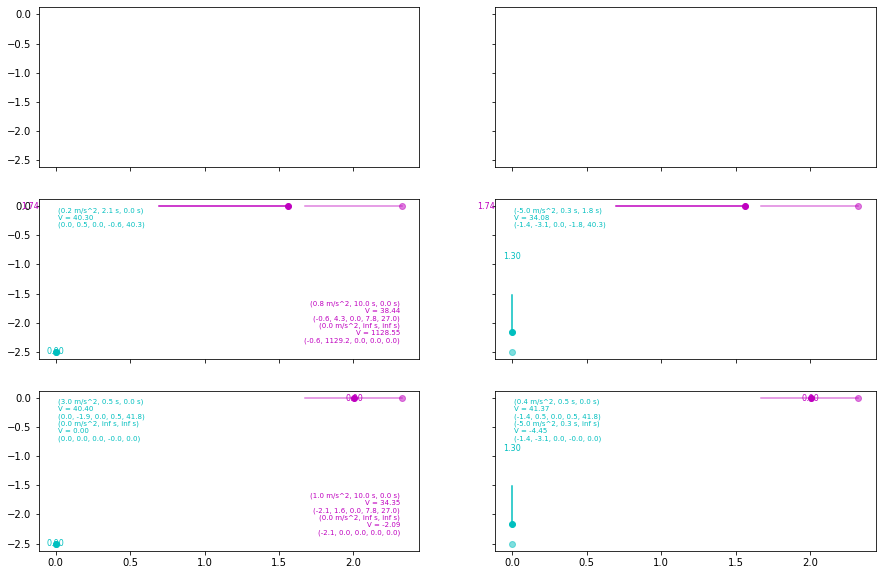

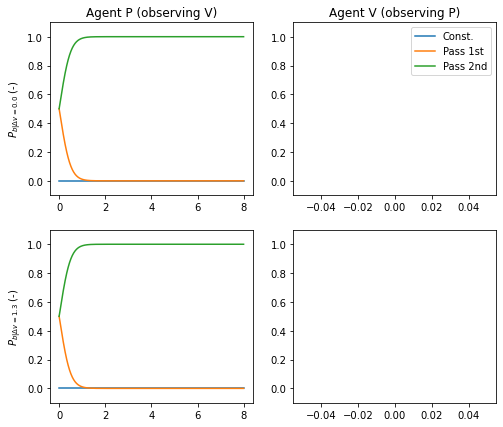

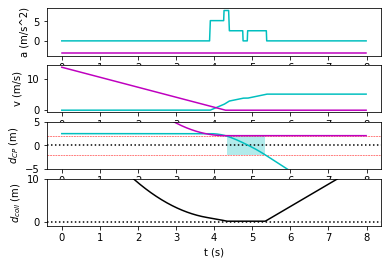

Agent P entered conflict area at t = 4.33 s
Agent V did not enter the conflict area.


In [27]:
run_keio_scenario(oBEo=False, time_step=0.01)
run_keio_scenario(oBEo=True, time_step=0.01, sigma_O=0.001, ped_snapshot_times=(3.89,))

---
If I now increase T_P to 1 s, I get an even bigger effect of `oBEo`:

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


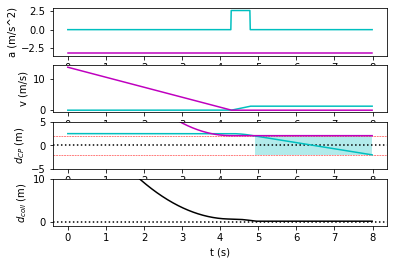

Agent P entered conflict area at t = 4.92 s
Agent V did not enter the conflict area.


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


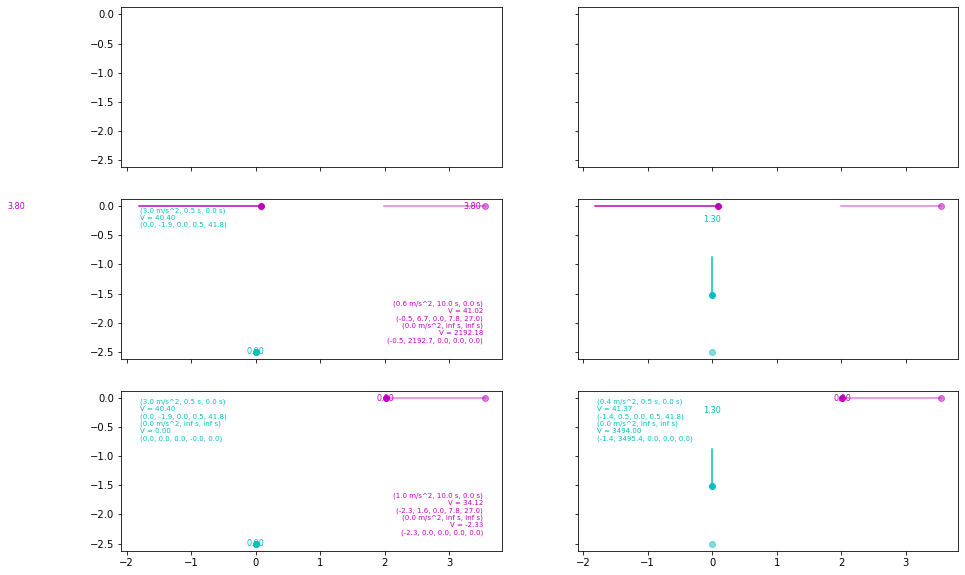

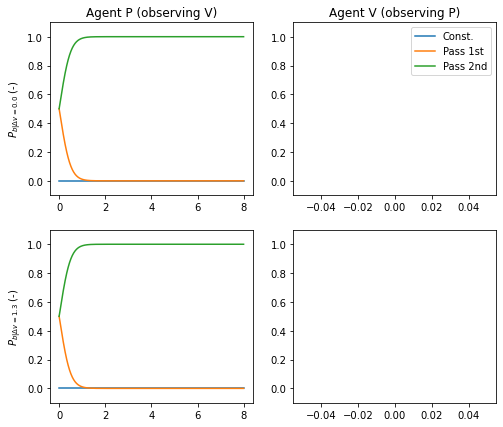

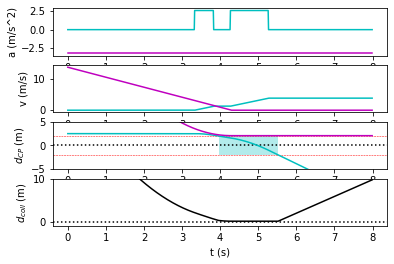

Agent P entered conflict area at t = 3.96 s
Agent V did not enter the conflict area.


In [29]:
run_keio_scenario(oBEo=False, T_P=1, time_step=0.01)
run_keio_scenario(oBEo=True, T_P=1, time_step=0.01, sigma_O=0.001, ped_snapshot_times=(3.33,))

---
The reason this now works out ok is that the predicted state of the car is a full stop in the snapshots shown above (just at the respective time steps the decision to start walking is made in the respective simulations), so passing in front of the car now looks safe. And the reason, in turn, why the predicted state of the car is now a full stop is that with the smaller time step, the precalculated yielding deceleration of the vehicle gets it to stop more exactly at the conflict space boundary. In the larger-time-step simulations above, due to numerical imprecision, the car short-stops by about 0.7 m or so, but since the "pass 2nd" behaviour acceleration is calculated so as to stop exactly at boundary, the expected deceleration is smaller, such that before the vehicle has come to an actual full stop, the prediction will consistently be that it will not yet have stopped fully T_P into the future.

This seems like an undesirable feature of the model, in at least a couple of different ways:
* The sensitivity to exactly where the car is actually stopping.
* The implication that a pedestrian agent (and maybe also a car driver agent, in some functionally equivalent scenario) would never pass in front of a car with which there is a potential collision conflict before the agent can predict that the car will come to a full stop within the prediction horizon T_P. 
    * In the constrained Keio study scenario simulated here, it sort of works, and the difference of about 0.5 s in crossing onset time between the model with/without taudot sensitivity in (Pekkanen et al., 2021) can be taken to suggest that the pedestrian's T_P is around 0.5 s. 
    * However, a corollary would be that eHMI can't get a pedestrian to start crossing, since it can only increase the estimated probability of the yielding behaviour (which is already near one in the simulations above), and not the predicted kinematics of that behaviour.
    * Furthermore, if one thinks about an even more general scenario, for example of a car driver passing green traffic lights, and seeing another car on the crossing road in the process of stopping at its red light, the current model could be entirely certain that the crossing car is about to stop, but it still would be very worried about it, and maybe slow down or yield.

I see two main possible fixes here:
1. Change things up so that the "access order implications" take into account not only positions and speeds of predicted states, as they currently do, but also accelerations. If so, as soon as the ego agent is 100% sure that the other agent is yielding, the ego agent should feel safe to cross.
2. Introduce a completely new type of assumption, that I have been thinking a bit about previously anyway, saying that there is positive value in behaving in line with the apparent expectations of other road users. So if the ego agent is certain that the other agent wants to pass in second, there is value added to the outcomes where the ego agent passes first.